In [32]:
import pandas as pd
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [33]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import SplineTransformer
import numpy as np

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

N_SPLINES = 5

df_hour = df.assign(hour=(np.arange(len(df)) % 24))
splines = periodic_spline_transformer(24, n_splines=N_SPLINES).fit_transform(df_hour[["hour"]])
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
df_hour_spline = df_hour.merge(splines_df, how = "left", left_on = "hour", right_index = True).drop(columns = "hour")

r2s = []
residuals = []
for target_col in df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")]:
    # get ridgecv r^2
    ridgecv = RidgeCV()
    ridgecv.fit(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col])
    r2s.append(ridgecv.score(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col]))
    # get residuals
    residuals.append(df_hour_spline[target_col] - ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]]))

residuals = pd.concat(residuals, axis = 1)
df = residuals
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,-22.342832,-3.116569,12.147587,2.659497,10.737338,7.930670,2.800332,5.890678,2.872822,5.581776,...,-14.639870,-1.024441,-17.414831,6.375465,-2.754792,-13.686524,-24.762748,-6.537448,-14.835954,-5.670398
2,-22.447433,-2.208705,10.809812,3.628737,10.438359,8.059212,4.797791,5.813972,3.246011,5.722668,...,-15.847779,-1.152319,-17.571162,4.909366,-3.189149,-13.681211,-25.443750,-8.145030,-15.763122,-6.063524
3,-22.676677,-1.477576,10.085036,4.815748,10.237478,7.903625,6.906874,5.945606,3.742143,6.139650,...,-16.369754,-1.402616,-16.728134,4.116709,-3.347336,-13.833561,-25.018517,-8.982367,-16.086097,-5.791371
4,-23.213525,-0.712179,9.870592,5.843948,10.169824,7.620348,7.438284,6.418208,4.053334,6.485583,...,-17.287671,-1.863507,-15.929542,4.037687,-3.393138,-13.273144,-24.296145,-9.164285,-16.087269,-5.721641
5,-23.731821,0.025469,9.695665,6.415877,10.125308,7.403772,7.801752,7.117694,4.440462,6.741828,...,-18.447805,-3.035762,-16.019500,4.445259,-3.466644,-12.530188,-23.495740,-9.257924,-15.850306,-6.221767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,17.083241,-30.182601,-27.858532,-34.156037,-33.964762,-32.256065,-30.243953,-31.774329,-31.944790,-37.305876,...,-16.694303,-10.125995,-13.974556,-10.676155,-13.005027,-12.207586,-13.308802,-11.471848,-16.863572,-17.216146
741,17.867075,-24.785405,-26.748385,-32.923775,-32.823620,-31.162104,-30.127614,-30.392634,-31.023014,-36.432742,...,-14.393872,-12.129205,-18.556645,-17.382790,-13.930290,-15.864623,-18.805135,-13.626348,-17.779144,-16.362235
742,16.935124,-21.773259,-27.914197,-34.602082,-33.770105,-1.014781,-30.457866,-30.396943,-33.260779,-37.035613,...,-19.065959,-12.222246,-21.348362,-21.493622,-17.901365,-29.529373,-24.783487,-17.248348,-20.093464,-20.157052


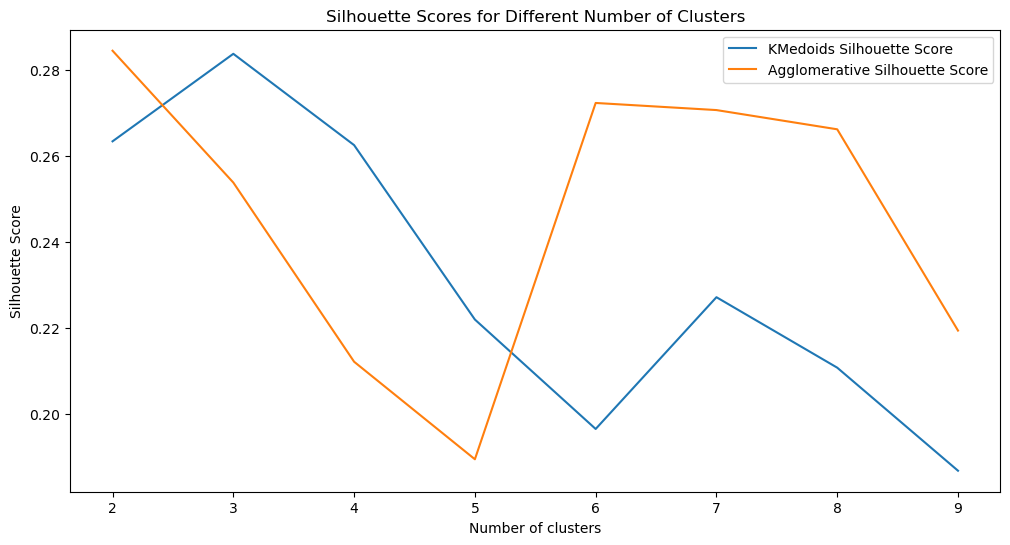

Best number of clusters for KMedoids: 3
Best number of clusters for Agglomerative: 2


In [43]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import numpy as np

def plot_silhouettes_clusters(range_n_clusters, scores, labels: list=None):
    if not isinstance(scores, list):
        scores = [scores]

    if labels is None:
        labels = [f'Model {i}' for i in range(len(scores))]
    
    
    
    # Plotting silhouette scores for each method
    plt.figure(figsize=(12, 6))
    for score, label in zip(scores, labels):
        plt.plot(range_n_clusters, score, label=label)
        # plt.plot(range_n_clusters, silhouette_scores_kmedoids, label='KMedoids Silhouette Score')
        # plt.plot(range_n_clusters, silhouette_scores_hierarchical, label='Agglomerative Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Number of Clusters')
    plt.legend()
    plt.show()


def find_optimal_clusters(data, range_n_clusters, random_state=0, transform=None, distance_matrix_func=None, plot=True,
                          return_all=False):
    """
    Finds the optimal number of clusters using silhouette scores for KMeans, AgglomerativeClustering, and KMedoids.
    Also returns the labels from the best models.
    
    Parameters:
    - data: DataFrame containing the features for clustering.
    - range_n_clusters: A range of cluster numbers to try.
    - random_state: Integer seed for reproducibility.
    - transform: Optional function to transform data before clustering.
    - distance_matrix_func: Optional function to compute a custom distance matrix.
    
    Returns:
    - Best number of clusters and labels for KMedoids and AgglomerativeClustering.
    """
    silhouette_scores_kmedoids = []
    silhouette_scores_hierarchical = []
    labels_kmedoids = []
    labels_hierarchical = []

    transformed_data = data.apply(transform) if transform is not None else data
    distance_matrix = distance_matrix_func(transformed_data) if distance_matrix_func is not None else None

    for n_clusters in range_n_clusters:
        # AgglomerativeClustering
        if distance_matrix is not None:
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
            cluster_labels_hierarchical = hierarchical.fit_predict(distance_matrix)
        else:
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
            cluster_labels_hierarchical = hierarchical.fit_predict(transformed_data.T)
        
        labels_hierarchical.append(cluster_labels_hierarchical)
        silhouette_avg_hierarchical = silhouette_score(data.T, cluster_labels_hierarchical)
        silhouette_scores_hierarchical.append(silhouette_avg_hierarchical)

        # KMedoids or KMeans
        if distance_matrix is not None:
            kmediods = KMedoids(n_clusters=n_clusters, metric="precomputed", random_state=random_state)
            cluster_labels_kmedoids = kmediods.fit_predict(distance_matrix)
        else:
            kmediods = KMeans(n_clusters=n_clusters, random_state=random_state)
            cluster_labels_kmedoids = kmediods.fit_predict(transformed_data.T)
        
        labels_kmedoids.append(cluster_labels_kmedoids)
        silhouette_avg_kmedoids = silhouette_score(data.T, cluster_labels_kmedoids)
        silhouette_scores_kmedoids.append(silhouette_avg_kmedoids)
    
    if plot:
        plot_silhouettes_clusters(range_n_clusters, 
                                  scores = [silhouette_scores_kmedoids, silhouette_scores_hierarchical],
                                  labels = ['KMedoids Silhouette Score', 'Agglomerative Silhouette Score'])

    best_index_kmedoids = np.argmax(silhouette_scores_kmedoids)
    best_index_hierarchical = np.argmax(silhouette_scores_hierarchical)
    
    best_n_clusters_kmedoids = range_n_clusters[best_index_kmedoids]
    best_n_clusters_hierarchical = range_n_clusters[best_index_hierarchical]

    print(f"Best number of clusters for KMedoids: {best_n_clusters_kmedoids}")
    print(f"Best number of clusters for Agglomerative: {best_n_clusters_hierarchical}")

    if return_all:
        return silhouette_scores_kmedoids, labels_kmedoids, silhouette_scores_hierarchical, labels_hierarchical

    labels_kmedoids_best = labels_kmedoids[best_index_kmedoids]
    labels_hierarchical_best = labels_hierarchical[best_index_hierarchical]
    
    return best_n_clusters_kmedoids, labels_kmedoids_best, best_n_clusters_hierarchical, labels_hierarchical_best


# Example usage:
range_n_clusters = list(range(2, 10))
best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42)

In [61]:
def plot_silhouette_scores_3d(configurations):
    fig = plt.figure(figsize=(14, 7))
    
    # KMedoids Silhouette Scores
    ax1 = fig.add_subplot(121, projection='3d')
    x1 = [config['n_clusters'] for config in configurations]
    y1 = [config['n_lags'] for config in configurations]
    z1 = [config['silhouette_score_kmedoids'] for config in configurations]
    
    ax1.scatter(x1, y1, z1, c=z1, cmap='viridis', marker='o')
    ax1.set_title('KMedoids Silhouette Scores')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Number of Lags')
    ax1.set_zlabel('Silhouette Score')
    
    # Hierarchical Clustering Silhouette Scores
    ax2 = fig.add_subplot(122, projection='3d')
    x2 = [config['n_clusters'] for config in configurations]
    y2 = [config['n_lags'] for config in configurations]
    z2 = [config['silhouette_score_hierarchical'] for config in configurations]
    
    ax2.scatter(x2, y2, z2, c=z2, cmap='viridis', marker='o')
    ax2.set_title('Hierarchical Clustering Silhouette Scores')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Number of Lags')
    ax2.set_zlabel('Silhouette Score')
    
    plt.tight_layout()
    plt.show()


def extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=0, transform=None, distance_matrix_func=None, plot=False):
    configurations = []
    
    for n_lags in range_n_lags:
        # Adjust distance matrix computation for the current number of lags
        distance_matrix = lambda data: distance_matrix_func(data, n_lags) if distance_matrix_func is not None else None
        
        # Retrieve all silhouette scores and labels for the current lag
        silhouette_scores_kmedoids, labels_kmedoids, silhouette_scores_hierarchical, labels_hierarchical = find_optimal_clusters(
            df, range_n_clusters, random_state, transform, 
            distance_matrix_func=distance_matrix, 
            plot=False, return_all=True
        )
        
        for index, n_clusters in enumerate(range_n_clusters):
            configurations.append({
                "n_clusters": n_clusters,
                "n_lags": n_lags,
                "silhouette_score_kmedoids": silhouette_scores_kmedoids[index],
                "labels_kmedoids": labels_kmedoids[index],
                "silhouette_score_hierarchical": silhouette_scores_hierarchical[index],
                "labels_hierarchical": labels_hierarchical[index]
            })
    
    if plot:
        plot_silhouette_scores_3d(configurations)
    
    # Sort and select top KMedoids configurations
    top_kmedoids = sorted(configurations, key=lambda x: x['silhouette_score_kmedoids'], reverse=True)[:k]

    # Sort and select top Hierarchical configurations
    top_hierarchical = sorted(configurations, key=lambda x: x['silhouette_score_hierarchical'], reverse=True)[:k]

    # Combine the top configurations into a single list using extend
    top_configurations = []
    top_configurations.extend(top_kmedoids)
    top_configurations.extend(top_hierarchical)
    
    # Print or return the top k configurations, depending on your needs
    for config in top_configurations:
        print(f"Number of Clusters: {config['n_clusters']}, Number of Lags: {config['n_lags']}, "
              f"Silhouette Score KMedoids: {config['silhouette_score_kmedoids']}, "
              f"Silhouette Score Hierarchical: {config['silhouette_score_hierarchical']}")
        # For detailed inspection, you can also access config['labels_kmedoids'] and config['labels_hierarchical']
    
    return top_configurations


In [35]:
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings

def get_max_order(df):
    warning_message_pattern = "An unsupported index was provided and will be ignored when e.g. forecasting."

    max_lags = []

    for column in df.columns:
        series_non_missing = df[column].dropna()  # Drop missing values for the current column
        n_obs_non_missing = len(series_non_missing)
        maxlag = min(10, n_obs_non_missing // 10)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ValueWarning, message=warning_message_pattern)
            mod = ar_select_order(df[column], maxlag=maxlag, trend='c', ic='bic')
        optimal_lags = len(mod.ar_lags) if mod.ar_lags is not None else 0
        max_lags.append(optimal_lags)

    # Find the maximum number of lags across all columns
    max_order = max(max_lags)
    return max_order

n_lags = get_max_order(df)

print(f"Maximum number of lags across all columns: {n_lags}")


Maximum number of lags across all columns: 6


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

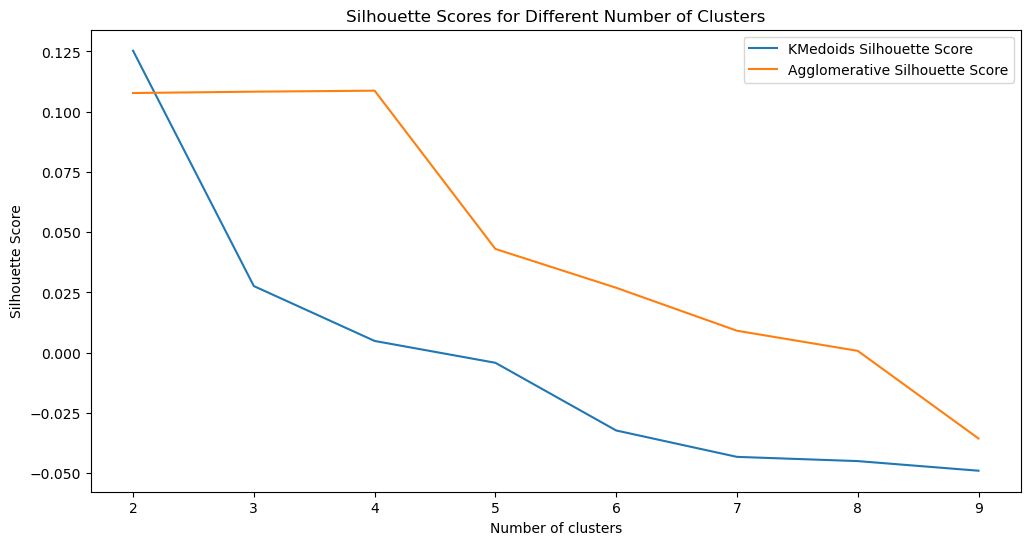

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 4


In [36]:
import pandas as pd
from statsmodels.tsa.stattools import acf

def calculate_acf(series, n_lags=5):
    """
    Calculate the Autocorrelation Function (ACF) for a given pandas Series.

    Parameters:
    - series: Pandas Series to calculate ACF for.
    - n_lags: Number of lags to calculate ACF for.

    Returns:
    - A pandas Series of ACF values for lags 1 to n_lags.
    """
    # Ensure series has no missing values and enough data points
    if series.dropna().shape[0] > n_lags: 
        acf_values = acf(series.dropna(), nlags=n_lags, fft=True)[1:] # Exclude lag 0
        return pd.Series(acf_values, index=[f'L{i}' for i in range(1, n_lags+1)])
    else: # Return NaNs if not enough data
        return pd.Series([pd.NA] * n_lags, index=[f'{i}' for i in range(1, n_lags+1)])


acf_df = df.apply(calculate_acf, n_lags=n_lags)

acf_df.head()
best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, 
                                                       transform=lambda data: calculate_acf(data, n_lags=n_lags))

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters f

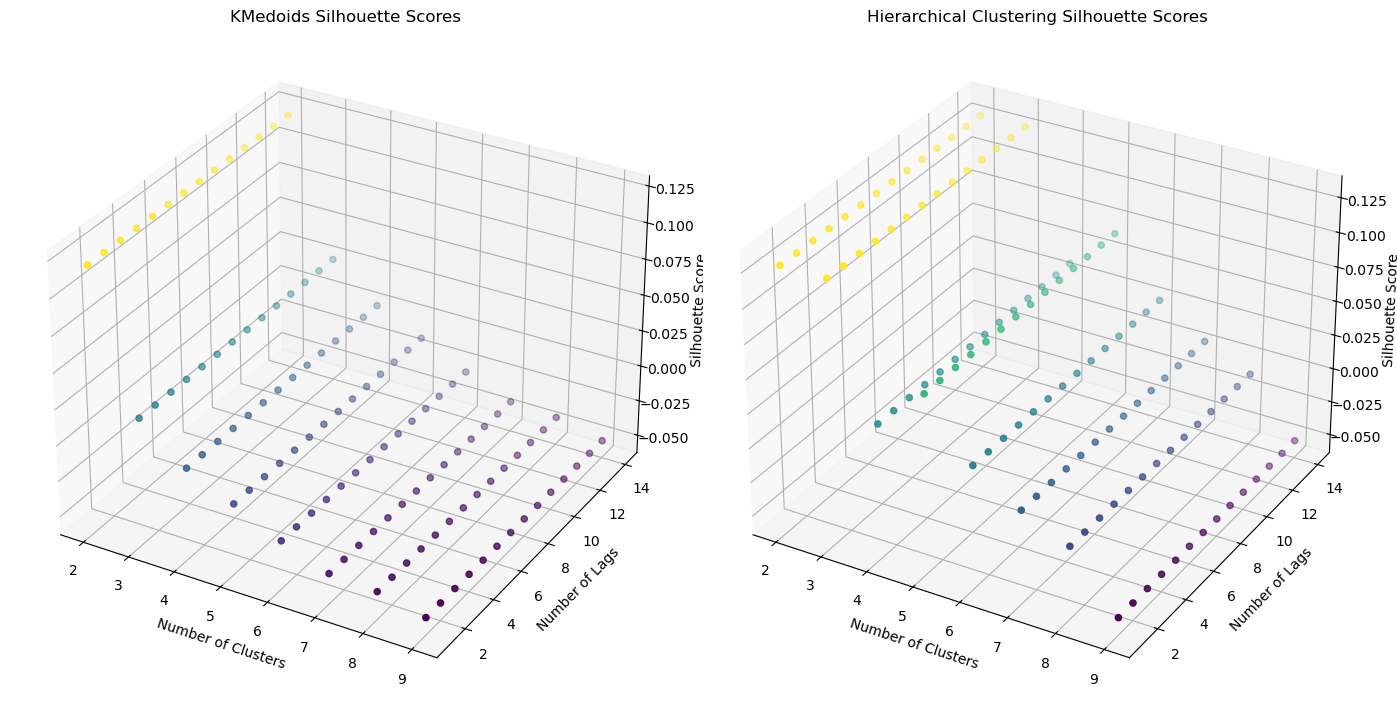

Number of Clusters: 2, Number of Lags: 1, Silhouette Score KMedoids: 0.11952064806358176, Silhouette Score Hierarchical: 0.12725073432942588
Number of Clusters: 2, Number of Lags: 2, Silhouette Score KMedoids: 0.11952064806358176, Silhouette Score Hierarchical: 0.12725073432942588
Number of Clusters: 2, Number of Lags: 3, Silhouette Score KMedoids: 0.11952064806358176, Silhouette Score Hierarchical: 0.12725073432942588
Number of Clusters: 2, Number of Lags: 4, Silhouette Score KMedoids: 0.11952064806358176, Silhouette Score Hierarchical: 0.12725073432942588
Number of Clusters: 2, Number of Lags: 5, Silhouette Score KMedoids: 0.11952064806358176, Silhouette Score Hierarchical: 0.12725073432942588
Number of Clusters: 3, Number of Lags: 1, Silhouette Score KMedoids: 0.025538520162828735, Silhouette Score Hierarchical: 0.12753585551152669
Number of Clusters: 3, Number of Lags: 2, Silhouette Score KMedoids: 0.025538520162828735, Silhouette Score Hierarchical: 0.12753585551152669
Number of C

In [64]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 15)  # Example range of lags
k = 5  # Number of top configurations to extract
top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, transform=calculate_acf, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

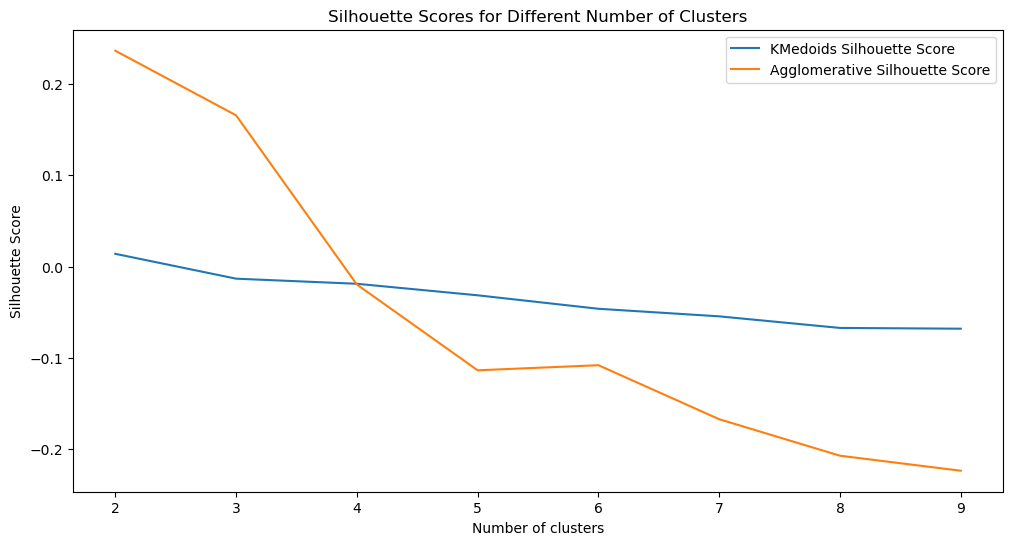

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [38]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

def fit_ar_and_extract_coeffs(series, n_lags=5, trend='c'):
    """
    Fits an AR model to a pandas Series and extracts the AR coefficients.
    
    Parameters:
    - series: Pandas Series to fit the AR model to.
    - n_lags: Number of lags for the AR model.
    - trend: Trend specification for the AR model ('n' for no trend, 'c' for constant).
    
    Returns:
    - A pandas Series of AR coefficients.
    """
    warning_message_pattern = "An unsupported index was provided and will be ignored when e.g. forecasting."

    if series.dropna().shape[0] > n_lags:  # Ensure enough data points
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ValueWarning, message=warning_message_pattern)
            ar_model = AutoReg(series.dropna(), lags=n_lags, trend=trend)
            ar_model_fitted = ar_model.fit()
        
        # Extract AR coefficients, skipping the intercept if trend is not 'n'
        coeffs = ar_model_fitted.params if trend == 'n' else ar_model_fitted.params[1:]
        coeffs.index = [f'L{i}' for i in range(1, len(coeffs)+1)]
        return coeffs
    else:
        # Return NaNs if not enough data
        return pd.Series([pd.NA] * n_lags, index=[f'L{i}' for i in range(1, n_lags+1)])

ar_coeffs_df = df.apply(fit_ar_and_extract_coeffs, n_lags=n_lags, trend='c')

ar_coeffs_df.head()

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, 
                                                       transform=lambda data: fit_ar_and_extract_coeffs(data, n_lags=n_lags))


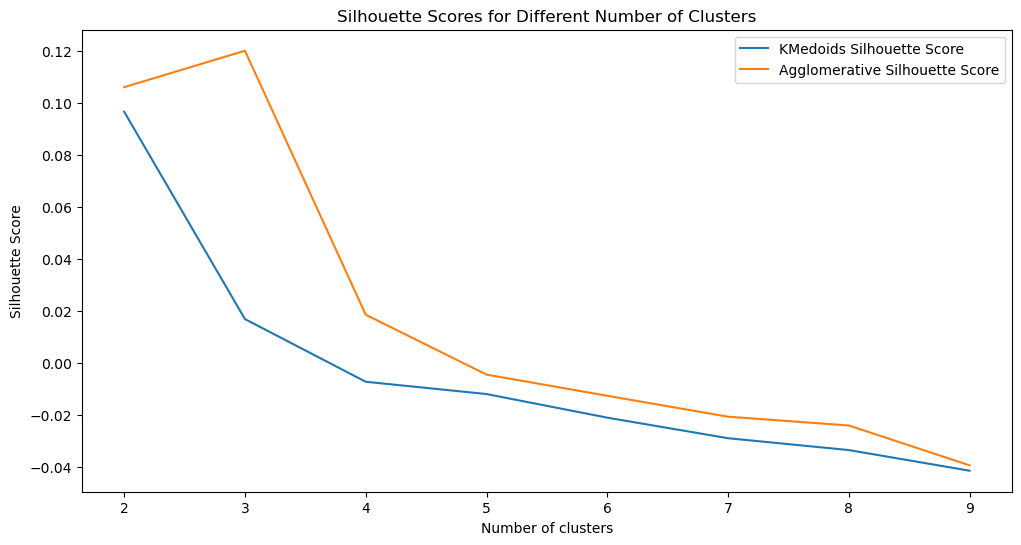

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3


In [39]:
def calculate_r_squared_autocorrelation(series, max_lag):
    # Compute autocorrelation values
    autocorr_values = acf(series, nlags=max_lag, fft=True)
    
    r_squared_values = []
    for i in range(1, max_lag + 1):
        # Construct the autocorrelation matrix up to lag i
        R_X_i = np.array([[autocorr_values[np.abs(j-k)] for k in range(i)] for j in range(i)])
        
        # Invert the autocorrelation matrix
        R_X_i_inv = np.linalg.inv(R_X_i)
        
        # Construct the autocorrelation vector up to lag i
        rho_X_1_i = np.array(autocorr_values[1:i+1]).reshape(-1, 1)
        
        # Calculate r^2 using the given formula
        r_squared = np.dot(np.dot(rho_X_1_i.T, R_X_i_inv), rho_X_1_i).item()
        r_squared_values.append(r_squared)
        
    return r_squared_values

def acf_dissimilarity(df, max_lag):
    r_squared_df = df.apply(lambda x: calculate_r_squared_autocorrelation(x, max_lag))
    
    # Sum of the logarithms for to avoid rounding errors
    log_sum = np.log(1 - r_squared_df).sum()

    # Exponentiate to negate log.
    geometric_mean_exp = np.exp(log_sum / (max_lag + 1)).to_numpy()

    acf_distance = np.abs(geometric_mean_exp[:, np.newaxis] - geometric_mean_exp[np.newaxis, :])
    return acf_distance

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
                                                         distance_matrix_func=lambda data: acf_dissimilarity(data, max_lag=n_lags))


Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters f

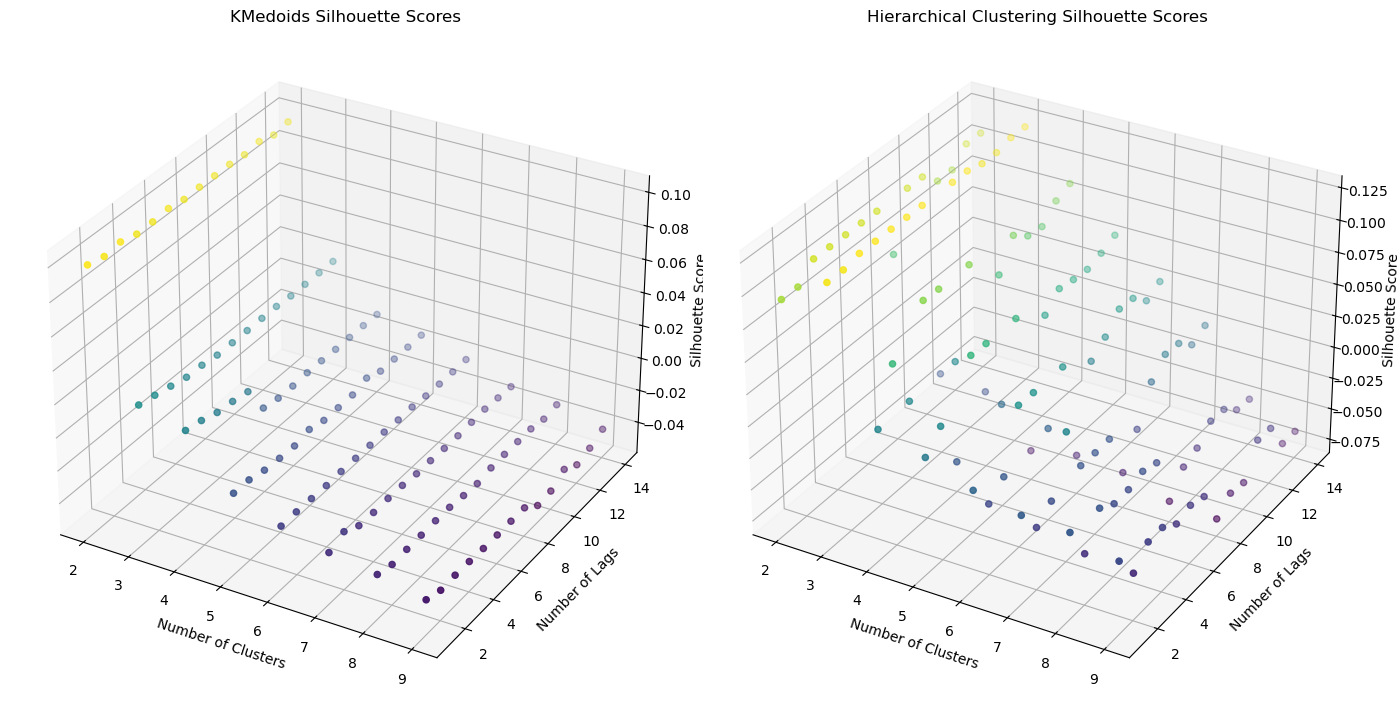

Number of Clusters: 2, Number of Lags: 1, Silhouette Score KMedoids: 0.09891100416029217, Silhouette Score Hierarchical: 0.0940949571631006
Number of Clusters: 2, Number of Lags: 3, Silhouette Score KMedoids: 0.09798854328114977, Silhouette Score Hierarchical: 0.10607337439442363
Number of Clusters: 2, Number of Lags: 2, Silhouette Score KMedoids: 0.09665456191644399, Silhouette Score Hierarchical: 0.0940949571631006
Number of Clusters: 2, Number of Lags: 6, Silhouette Score KMedoids: 0.09663427054485609, Silhouette Score Hierarchical: 0.10607337439442363
Number of Clusters: 2, Number of Lags: 12, Silhouette Score KMedoids: 0.09616124031848557, Silhouette Score Hierarchical: 0.0940949571631006
Number of Clusters: 3, Number of Lags: 3, Silhouette Score KMedoids: 0.0209813731478513, Silhouette Score Hierarchical: 0.12009700903297874
Number of Clusters: 3, Number of Lags: 4, Silhouette Score KMedoids: 0.01864247331953448, Silhouette Score Hierarchical: 0.12009700903297874
Number of Cluste

In [67]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 15)  # Example range of lags
k = 5  # Number of top configurations to extract
acf_top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, distance_matrix_func=acf_dissimilarity, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

In [7]:
acf_distance = acf_dissimilarity(df, n_lags)
acf_distance

array([[0.        , 0.04183372, 0.06373729, ..., 0.05590676, 0.05149934,
        0.05520917],
       [0.04183372, 0.        , 0.02190356, ..., 0.09774049, 0.09333306,
        0.0970429 ],
       [0.06373729, 0.02190356, 0.        , ..., 0.11964405, 0.11523662,
        0.11894646],
       ...,
       [0.05590676, 0.09774049, 0.11964405, ..., 0.        , 0.00440743,
        0.00069759],
       [0.05149934, 0.09333306, 0.11523662, ..., 0.00440743, 0.        ,
        0.00370984],
       [0.05520917, 0.0970429 , 0.11894646, ..., 0.00069759, 0.00370984,
        0.        ]])

In [68]:
from statsmodels.tsa.stattools import ccf
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D

def compute_autocorrelation_norms(df, h):
    norms = {}
    for column in df.columns:
        series = df[column].dropna()  # Ensure no NaN values
        ccf_values = ccf(series, series, adjusted=True)
        first = list(reversed(ccf_values[1:h]))
        second = ccf_values[:h]
        autocorr_values = np.concatenate([first, second])
        norms[column] = np.linalg.norm(autocorr_values)
    return norms

def compute_cc_matrix(df, h):
    n = df.shape[1]  # Number of series
    cc_matrix = np.zeros((n, n))
    
    # Precompute autocorrelation norms for each series
    autocorr_norms = compute_autocorrelation_norms(df, h)
    

    for i in tqdm(range(n)):
        for j in range(i+1, n):  # The matrix is symmetric
            series_i = df.iloc[:, i].dropna()
            series_j = df.iloc[:, j].dropna()
            
            # Compute cross-correlation for lags -h to h
            first = list(reversed(ccf(series_j, series_i, adjusted=True)[1:h]))
            second = ccf(series_i, series_j, adjusted=True)[:h]
            cross_correlations = np.concatenate([first, second])
            norm_xy = np.linalg.norm(cross_correlations)
            
            # Use precomputed autocorrelation norms
            norm_xx = autocorr_norms[df.columns[i]]
            norm_yy = autocorr_norms[df.columns[j]]

            # Compute DCC,h dissimilarity
            cc_ij = 1 - (norm_xy**2) / (norm_xx * norm_yy)
            cc_matrix[i, j] = cc_matrix[j, i] = cc_ij
            
    return cc_matrix


# best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
#                                                          distance_matrix_func=lambda data: compute_cc_matrix(data, n_lags // 2))


In [75]:
results = {
    "acf": acf_top_k_configurations
    }

import json




In [76]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 7)  # Example range of lags
k = 5  # Number of top configurations to extract
cc_top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, distance_matrix_func=compute_cc_matrix, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

  0%|          | 0/516 [00:00<?, ?it/s]

In [ ]:
# Example usage
cc_matrix = compute_cc_matrix(df, n_lags // 2)
cc_matrix

  0%|          | 0/516 [00:00<?, ?it/s]

array([[0.        , 0.98676967, 0.97444837, ..., 0.99988466, 0.99886758,
        0.99852414],
       [0.98676967, 0.        , 0.13115139, ..., 0.99942679, 0.99971149,
        0.99130292],
       [0.97444837, 0.13115139, 0.        , ..., 0.99874803, 0.99469768,
        0.99850934],
       ...,
       [0.99988466, 0.99942679, 0.99874803, ..., 0.        , 0.07556206,
        0.35830547],
       [0.99886758, 0.99971149, 0.99469768, ..., 0.07556206, 0.        ,
        0.29935375],
       [0.99852414, 0.99130292, 0.99850934, ..., 0.35830547, 0.29935375,
        0.        ]])

In [ ]:
import os
os.environ['R_HOME'] = '/usr/lib/R/'

import rpy2
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

base = importr('base')
utils = importr('utils')
SLBDD = importr('SLBDD')

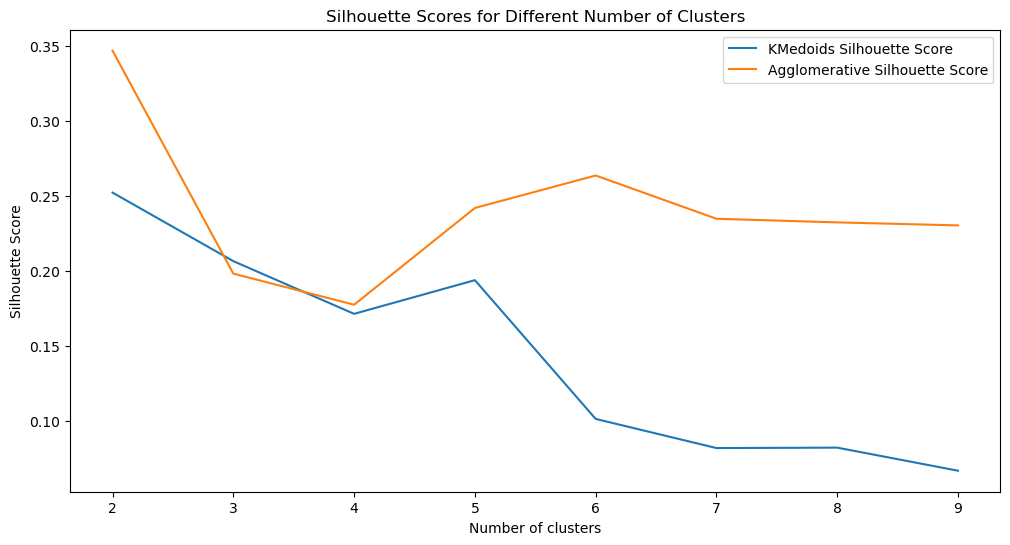

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [ ]:
def compute_gcc_matrix(df, n_lags):
    r_df = pandas2ri.py2rpy(df)
    result = SLBDD.GCCmatrix(r_df, n_lags)
    gcc_distance_matrix = result.rx2('DM')
    return gcc_distance_matrix

# best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
#                                                          distance_matrix_func=lambda data: compute_gcc_matrix(data, n_lags))


In [ ]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 7)  # Example range of lags
k = 5  # Number of top configurations to extract
gcc_top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, distance_matrix_func=compute_gcc_matrix, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

In [ ]:
gcc_distance_matrix = compute_gcc_matrix(df, n_lags)
gcc_distance_matrix

array([[0.        , 0.98790944, 0.98831155, ..., 0.99345315, 0.99431862,
        0.99544578],
       [0.98790944, 0.        , 0.49184932, ..., 0.98887122, 0.98880293,
        0.98610912],
       [0.98831155, 0.49184932, 0.        , ..., 0.98138246, 0.98730847,
        0.99180628],
       ...,
       [0.99345315, 0.98887122, 0.98138246, ..., 0.        , 0.38109674,
        0.76979739],
       [0.99431862, 0.98880293, 0.98730847, ..., 0.38109674, 0.        ,
        0.69421347],
       [0.99544578, 0.98610912, 0.99180628, ..., 0.76979739, 0.69421347,
        0.        ]])

In [ ]:
import json

results = {
    "acf": acf_top_k_configurations,
    "cc": cc_top_k_configurations,
    "gcc": gcc_top_k_configurations
}

def serialize_configurations(configurations):
    """
    Convert clustering configurations to a serializable format for JSON, including handling lists and NumPy arrays.
    
    Args:
    - configurations (dict): A dictionary where keys are configuration names or identifiers,
      and values are the configurations, which may include non-serializable types like NumPy arrays and lists containing such types.
    
    Returns:
    - dict: A dictionary with the same structure as `configurations` but with all values converted
      to serializable types.
    """
    def serialize_value(value):
        """Recursively serialize any value to a JSON-serializable format."""
        if hasattr(value, 'tolist'):
            # Convert NumPy array to list
            return value.tolist()
        elif isinstance(value, list):
            # Recursively serialize each item in the list
            return [serialize_value(item) for item in value]
        elif isinstance(value, dict):
            # Recursively serialize dictionary values
            return {k: serialize_value(v) for k, v in value.items()}
        else:
            # Assume the value is already serializable (e.g., int, float, str)
            return value

    # Serialize each configuration in the dictionary
    return {key: serialize_value(config) for key, config in configurations.items()}


# Serialize and save to JSON
with open('./out/clustering_results.json', 'w') as f:
    json.dump(serialize_configurations(results), f)
